In [1]:
import os
import time
from ROOT import *

def add_parent_lib_path(name="Pheno_BSM"):
    import sys
    sys.path.append(
        os.path.join(
            sys.path[0].split(name)[0],name
        )
    )
add_parent_lib_path()

from ml_tools import Log_Reg_Classifier
from ml_tools import XGB_Classifier

Welcome to JupyROOT 6.26/06


In [2]:
def get_signal_names(mass):
    if mass < 1000:
        name=f"LQ_LQ_0{mass}"
        name2=f"Tau_LQ_0{mass}"
    else :
        name=f"LQ_LQ_{mass}"
        name2=f"Tau_LQ_{mass}"
    signal_names=[name, name2]

    return signal_names
def get_features_by_channel(channel):
    part_dict={
        "b_tau_tau_hadronic":[
            "b_{1}",
            "#tau_{1}",
            "#tau_{2}"
            ],
        "b_b_tau_tau_hadronic" :[
            "b_{1}",
            "b_{2}",
            "#tau_{1}",
            "#tau_{2}"
            ],
        "b_tau_tau_semileptonic" :[
            "b_{1}",
            "#tau_{1}",
            "lep_{1}"
            ],
        "b_b_tau_tau_semileptonic" :[
            "b_{1}",
            "b_{2}",
            "#tau_{1}",
            "lep_{1}"
            ]
    }
    key=channel
    n_Tod=len(part_dict[key])
    lep_a=part_dict[key][n_Tod-2]
    lep_b=part_dict[key][n_Tod-1]

    co_particles=part_dict[key].copy()
    features=[
        'MET(GeV)',
        '#phi_{MET}',
        f"Q_{{{lep_a}}}Q_{{{lep_b}}}",
        'light_jets_multiplicity',
        #'mT(GeV)',
        'sT(GeV)',
    ]
    for particle in part_dict[key]:
        features+=[
            f'Energy_{{{particle}}}(GeV)',
            f'pT_{{{particle}}}(GeV)',
            f'#phi_{{{particle}}}',
            f'#eta_{{{particle}}}'
        ]
        co_particles.pop(0)
        for co_particle in co_particles:
            features+=[f"#Delta R_{{{particle}{co_particle}}}"]
            features+=[f"#Delta #eta_{{{particle}{co_particle}}}"]
            features+=[f"#Delta #phi_{{{particle}{co_particle}}}"]
            features+=[f"#Delta pT_{{{particle}{co_particle}}}(GeV)"]
            features+=[f"#Delta #vec{{pT}}_{{{particle}{co_particle}}}(GeV)"]
            features+=[f"#Delta #vec{{p}}_{{{particle}{co_particle}}}(GeV)"]
            
    return features

In [3]:
folder_out=os.path.join(
    os.path.dirname(os.getcwd()),
    "03_delphes_preselection"
)
csv_files_path=os.path.join(folder_out,"Selected_Events")

masses=list(range(250,2500+1,250))
test_parameters={
    "n_estimators":[
        250,
        500,
        750,
        1000
    ],
    "max_depth":[
        3,
        5,
        7,
        9
    ],
    "learning_rate":[
        0.1
    ]
}

bkgs=[
        "ttbar",
        "stop",
        "w_jets",
        "z_jets",
        "ww",
        "wz",
        "zz"
    ]

In [4]:
mass=1500
channel="b_tau_tau_hadronic"
signals=get_signal_names(mass)
feats=get_features_by_channel(channel)
feats.sort()
xbg_class=XGB_Classifier(
    features=feats,
    channels=[channel],
    csv_files_path=csv_files_path,
    bkg_names=bkgs,
    signal_names=signals,
    parameters=test_parameters
)
df=xbg_class.get_features_corr()

<AxesSubplot:>

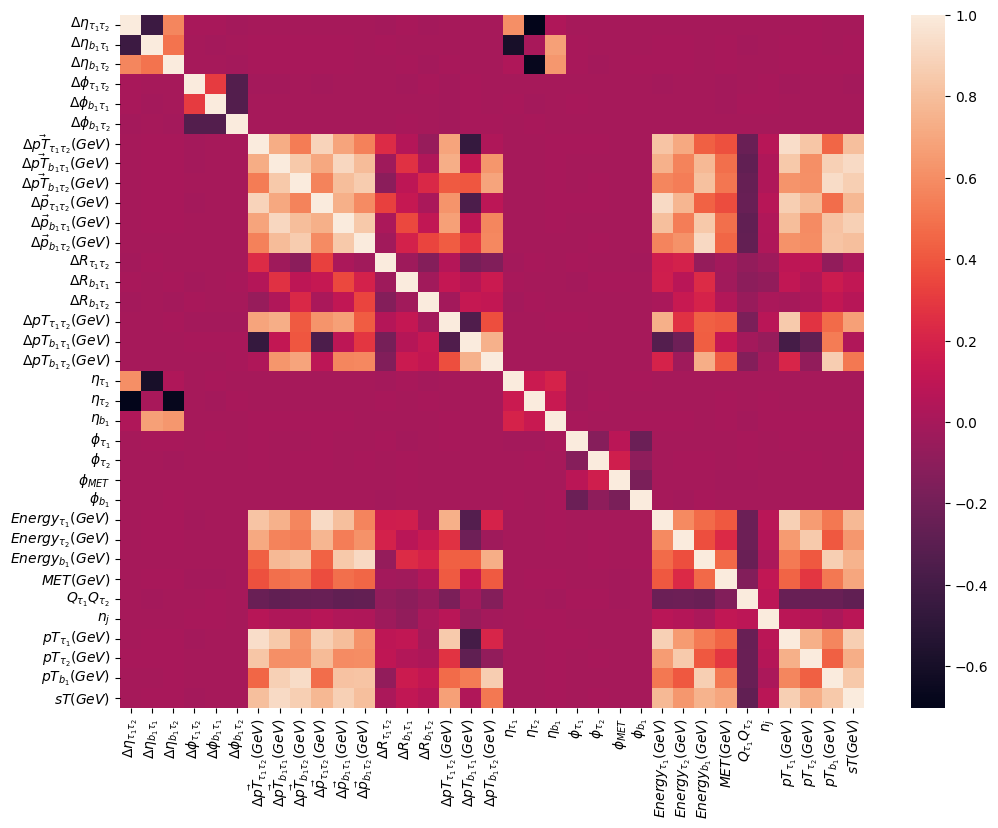

In [5]:
import seaborn as sns
from matplotlib import pyplot
pyplot.figure(figsize=(12, 9))#inches
sns.heatmap(df, xticklabels=True, yticklabels=True)

In [6]:
start_time = time.time()
xbg_class.fit_model()
elapsed=(time.time() - start_time)/3600.
print(f"done! time elapsed: {elapsed} hours.")
xbg_class.model.fpr(xbg_class.testLab,preds=xbg_class.testPred)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
For the ['LQ_LQ_1500', 'Tau_LQ_1500'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 750}
the train accuracy is 1.0
the test accuracy is 0.9882192419048886
the most important variables are
                                          0         1
0                                   sT(GeV)  0.885124
1                  Q_{#tau_{1}}Q_{#tau_{2}}  0.016890
2                  #Delta R_{b_{1}#tau_{1}}  0.005265
3               #Delta #eta_{b_{1}#tau_{1}}  0.005029
4               #Delta #eta_{b_{1}#tau_{2}}  0.004766
5                           pT_{b_{1}}(GeV)  0.004424
6    #Delta #vec{p}_{#tau_{1}#tau_{2}}(GeV)  0.004240
7                  #Delta R_{b_{1}#tau_{2}}  0.004207
8      #Delta #vec{pT}_{b_{1}#tau_{1}}(GeV)  0.004124
9       #Delta #vec{p}_{b_{1}#tau_{2}}(GeV)  0.003478
10                   Energy_{#tau_{2}}(GeV)  0.003392
11     #Delta #vec{pT}_{b_{1}#tau_{2}}(GeV)  0.003279
12        

0.010515806988352746

In [7]:
ask="$"+xbg_class.importances_df[0][0].replace("#","\\")+"$"
corr_var=[]
for key in df[ask].keys():
    if key == ask: continue
    elif abs(df[ask][key]) >=0.60 :
        featkey=key.replace("\\","#").removesuffix("$").removeprefix("$")
        corr_var+=[featkey]
        print(featkey, df[ask][key])

#Delta #vec{pT}_{#tau_{1}#tau_{2}}(GeV) 0.8039117374430198
#Delta #vec{pT}_{b_{1}#tau_{1}}(GeV) 0.9218891225264646
#Delta #vec{pT}_{b_{1}#tau_{2}}(GeV) 0.8695339565935364
#Delta #vec{p}_{#tau_{1}#tau_{2}}(GeV) 0.772942391577999
#Delta #vec{p}_{b_{1}#tau_{1}}(GeV) 0.875489331717238
#Delta #vec{p}_{b_{1}#tau_{2}}(GeV) 0.8064138104713944
#Delta pT_{#tau_{1}#tau_{2}}(GeV) 0.6712942377006931
Energy_{#tau_{1}}(GeV) 0.778671817261201
Energy_{#tau_{2}}(GeV) 0.6407621918781021
Energy_{b_{1}}(GeV) 0.7526723067109279
MET(GeV) 0.6992537188210497
pT_{#tau_{1}}(GeV) 0.8721263397074945
pT_{#tau_{2}}(GeV) 0.7316207860277899
pT_{b_{1}}(GeV) 0.8424764083802476


In [8]:
important_feats=[]
for important in list(xbg_class.importances_df[0]):
    ask="$"+important.replace("#","\\")+"$"
    if ask == '$light_jets_multiplicity$':continue
    corr_var=[]
    for key in df[ask].keys():
        if key == ask: continue
        elif abs(df[ask][key]) >=0.60 :
            featkey=key.replace("\\","#").removesuffix("$").removeprefix("$")
            corr_var+=[featkey]
            #print(featkey, df[ask][key])
    for j, feat in enumerate(feats):
        if len(feats) < 10: continue
        if (feat in corr_var) and not(feat in important_feats):
            feats.pop(j)
    if (important in feats) and not (len(important_feats)>=10):
        important_feats+=[important]
important_feats

['sT(GeV)',
 'Q_{#tau_{1}}Q_{#tau_{2}}',
 '#Delta R_{b_{1}#tau_{1}}',
 '#Delta #eta_{b_{1}#tau_{1}}',
 '#Delta #eta_{b_{1}#tau_{2}}',
 '#Delta #vec{p}_{#tau_{1}#tau_{2}}(GeV)',
 '#Delta R_{b_{1}#tau_{2}}',
 '#Delta #eta_{#tau_{1}#tau_{2}}',
 '#Delta R_{#tau_{1}#tau_{2}}',
 '#Delta #phi_{#tau_{1}#tau_{2}}']

In [9]:
xbg_class=XGB_Classifier(
    features=important_feats,
    channels=[channel],
    csv_files_path=csv_files_path,
    bkg_names=bkgs,
    signal_names=signals,
    parameters=test_parameters
)
df=xbg_class.get_features_corr()

<AxesSubplot:>

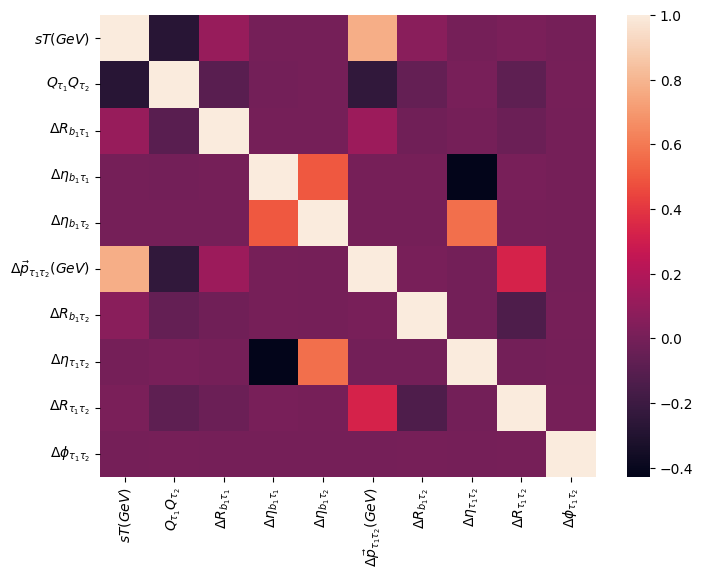

In [10]:
import seaborn as sns
from matplotlib import pyplot
pyplot.figure(figsize=(8, 6))#inches
sns.heatmap(df, xticklabels=True, yticklabels=True)

In [11]:
start_time = time.time()
xbg_class.fit_model()
elapsed=(time.time() - start_time)/3600.
print(f"done! time elapsed: {elapsed} hours.")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
For the ['LQ_LQ_1500', 'Tau_LQ_1500'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
the train accuracy is 0.9908433528732189
the test accuracy is 0.988518752703917
the most important variables are
                                        0         1
0                                 sT(GeV)  0.902497
1                Q_{#tau_{1}}Q_{#tau_{2}}  0.033036
2  #Delta #vec{p}_{#tau_{1}#tau_{2}}(GeV)  0.016341
3             #Delta #eta_{b_{1}#tau_{1}}  0.010748
4             #Delta #eta_{b_{1}#tau_{2}}  0.008905
5                #Delta R_{b_{1}#tau_{1}}  0.007760
6                #Delta R_{b_{1}#tau_{2}}  0.007264
7             #Delta R_{#tau_{1}#tau_{2}}  0.005737
8          #Delta #phi_{#tau_{1}#tau_{2}}  0.004074
9          #Delta #eta_{#tau_{1}#tau_{2}}  0.003638
done! time elapsed: 0.09006323403782315 hours.


In [12]:
xbg_class.model.fpr(xbg_class.testLab,preds=xbg_class.testPred)

0.010613598673300166

In [13]:
images_folder=os.path.join(f"MLQ_{mass}",f"{channel}")
os.system(f"mkdir -p '{images_folder}'")
xbg_class.get_discriminator_histograms(images_folder)

{'LQ_LQ_1500': {'b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55c8979c2480>},
 'Tau_LQ_1500': {'b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55c89f82c800>},
 'ttbar': {'b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55c8979c99c0>},
 'stop': {'b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55c89aaae8b0>},
 'w_jets': {'b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55c89aaae0d0>},
 'z_jets': {'b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55c89aaadce0>},
 'ww': {'b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55c89cdbd8c0>},
 'wz': {'b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55c89c3acdc0>},
 'zz': {'b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55c89cef6830>}}

Info in <TCanvas::Print>: png file MLQ_1500/b_tau_tau_hadronic/Gradient_Boosting_LQ_LQ_1500.png has been created
Info in <TCanvas::Print>: png file MLQ_1500/b_tau_tau_hadronic/Gradient_Boosting_Tau_LQ_1500.png has been created
Info in <TCanvas::Print>: png file MLQ_1500/b_tau_tau_hadronic/Gradient_Boosting_ttbar.png has been created
Info in <TCanvas::Print>: png file MLQ_1500/b_tau_tau_hadronic/Gradient_Boosting_stop.png has been created
Info in <TCanvas::Print>: png file MLQ_1500/b_tau_tau_hadronic/Gradient_Boosting_w_jets.png has been created
Info in <TCanvas::Print>: png file MLQ_1500/b_tau_tau_hadronic/Gradient_Boosting_z_jets.png has been created
Info in <TCanvas::Print>: png file MLQ_1500/b_tau_tau_hadronic/Gradient_Boosting_ww.png has been created
Info in <TCanvas::Print>: png file MLQ_1500/b_tau_tau_hadronic/Gradient_Boosting_wz.png has been created
Info in <TCanvas::Print>: png file MLQ_1500/b_tau_tau_hadronic/Gradient_Boosting_zz.png has been created


In [14]:
def get_important_features(channel):
    mass=1500
    signals=get_signal_names(mass)
    feats=get_features_by_channel(channel)
    feats.sort()
    xbg_class=XGB_Classifier(
        features=feats,
        channels=[channel],
        csv_files_path=csv_files_path,
        bkg_names=bkgs,
        signal_names=signals,
        parameters=test_parameters
    )
    df=xbg_class.get_features_corr()
    xbg_class.fit_model()
    important_feats=[]
    for important in list(xbg_class.importances_df[0]):
        ask="$"+important.replace("#","\\")+"$"
        if ask == '$light_jets_multiplicity$':continue
        corr_var=[]
        for key in df[ask].keys():
            if key == ask: continue
            elif abs(df[ask][key]) >=0.60 :
                featkey=key.replace("\\","#").removesuffix("$").removeprefix("$")
                corr_var+=[featkey]
                #print(featkey, df[ask][key])
        for j, feat in enumerate(feats):
            if len(feats) < 10: continue
            if (feat in corr_var) and not(feat in important_feats):
                feats.pop(j)
        if (important in feats) and not (len(important_feats)>=10):
            important_feats+=[important]
    return important_feats

In [15]:
channel="b_tau_tau_hadronic"
feats=get_important_features(channel)
def doit(mass):
    start_time = time.time()
    signals=get_signal_names(mass)
    xbg_class=XGB_Classifier(
        features=feats,
        channels=[channel],
        csv_files_path=csv_files_path,
        bkg_names=bkgs,
        signal_names=signals,
        parameters=test_parameters,
        cv=5
    )
    log_reg_class=Log_Reg_Classifier(
        features=feats,
        channels=[channel],
        csv_files_path=csv_files_path,
        bkg_names=bkgs,
        signal_names=signals
    )
    xbg_class.fit_model()
    log_reg_class.fit_model()
    images_folder=os.path.join(f"MLQ_{mass}",f"{channel}")
    os.system(f"rm -rf '{images_folder}'")
    os.system(f"mkdir -p '{images_folder}'")
    log_reg_histos=log_reg_class.get_discriminator_histograms(images_folder)
    xbg_histos=xbg_class.get_discriminator_histograms(images_folder)
    elapsed=(time.time() - start_time)/3600.
    print(f"{mass} done! time elapsed: {elapsed} hours.")
    return f"Done {mass}", mass
dict(map(doit,masses))
print(csv_files_path)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
For the ['LQ_LQ_1500', 'Tau_LQ_1500'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500}
the train accuracy is 1.0
the test accuracy is 0.9882192419048886
the most important variables are
                                          0         1
0                                   sT(GeV)  0.880026
1                  Q_{#tau_{1}}Q_{#tau_{2}}  0.018899
2               #Delta #eta_{b_{1}#tau_{2}}  0.005160
3               #Delta #eta_{b_{1}#tau_{1}}  0.005007
4                  #Delta R_{b_{1}#tau_{1}}  0.004897
5                           pT_{b_{1}}(GeV)  0.004570
6    #Delta #vec{p}_{#tau_{1}#tau_{2}}(GeV)  0.004116
7      #Delta #vec{pT}_{b_{1}#tau_{1}}(GeV)  0.003951
8                  #Delta R_{b_{1}#tau_{2}}  0.003732
9            #Delta #eta_{#tau_{1}#tau_{2}}  0.003717
10      #Delta #vec{p}_{b_{1}#tau_{1}}(GeV)  0.003572
11              #Delta #phi_{b_{1}#tau_{1}}  0.003403
12  #Delta

Info in <TCanvas::Print>: png file MLQ_250/b_tau_tau_hadronic/Logistic_Regression_LQ_LQ_0250.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_tau_tau_hadronic/Logistic_Regression_Tau_LQ_0250.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_tau_tau_hadronic/Logistic_Regression_ttbar.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_tau_tau_hadronic/Logistic_Regression_stop.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_tau_tau_hadronic/Logistic_Regression_w_jets.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_tau_tau_hadronic/Logistic_Regression_z_jets.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_tau_tau_hadronic/Logistic_Regression_ww.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_tau_tau_hadronic/Logistic_Regression_wz.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_tau_tau_hadronic/Logistic_Regression_zz.png has been created
Info in <TCanvas

In [16]:
channel="b_tau_tau_semileptonic"
feats=get_important_features(channel)
def doit(mass):
    start_time = time.time()
    signals=get_signal_names(mass)
    xbg_class=XGB_Classifier(
        features=feats,
        channels=[channel],
        csv_files_path=csv_files_path,
        bkg_names=bkgs,
        signal_names=signals,
        parameters=test_parameters,
        cv=5
    )
    log_reg_class=Log_Reg_Classifier(
        features=feats,
        channels=[channel],
        csv_files_path=csv_files_path,
        bkg_names=bkgs,
        signal_names=signals
    )
    xbg_class.fit_model()
    log_reg_class.fit_model()
    images_folder=os.path.join(f"MLQ_{mass}",f"{channel}")
    os.system(f"rm -rf '{images_folder}'")
    os.system(f"mkdir -p '{images_folder}'")
    log_reg_histos=log_reg_class.get_discriminator_histograms(images_folder)
    xbg_histos=xbg_class.get_discriminator_histograms(images_folder)
    elapsed=(time.time() - start_time)/3600.
    print(f"{mass} done! time elapsed: {elapsed} hours.")
    return f"Done {mass}", mass
dict(map(doit,masses))
print(csv_files_path)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
For the ['LQ_LQ_1500', 'Tau_LQ_1500'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
the train accuracy is 0.9983668857847166
the test accuracy is 0.9863154867468724
the most important variables are
                                         0         1
0                                  sT(GeV)  0.865776
1                  Q_{#tau_{1}}Q_{lep_{1}}  0.016653
2               #Delta #eta_{b_{1}lep_{1}}  0.008115
3              #Delta #eta_{b_{1}#tau_{1}}  0.006401
4                                 MET(GeV)  0.006227
5                  #Delta R_{b_{1}lep_{1}}  0.005897
6                          pT_{b_{1}}(GeV)  0.005117
7            #Delta #eta_{#tau_{1}lep_{1}}  0.004811
8    #Delta #vec{p}_{#tau_{1}lep_{1}}(GeV)  0.004120
9                 #Delta R_{b_{1}#tau_{1}}  0.003985
10     #Delta #vec{p}_{b_{1}#tau_{1}}(GeV)  0.003863
11      #Delta #vec{p}_{b_{1}lep_{1}}(GeV)  0.003834
12      

Info in <TCanvas::Print>: png file MLQ_250/b_tau_tau_semileptonic/Logistic_Regression_LQ_LQ_0250.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_tau_tau_semileptonic/Logistic_Regression_Tau_LQ_0250.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_tau_tau_semileptonic/Logistic_Regression_ttbar.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_tau_tau_semileptonic/Logistic_Regression_stop.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_tau_tau_semileptonic/Logistic_Regression_w_jets.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_tau_tau_semileptonic/Logistic_Regression_z_jets.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_tau_tau_semileptonic/Logistic_Regression_ww.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_tau_tau_semileptonic/Logistic_Regression_wz.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_tau_tau_semileptonic/Logistic_Regression_zz.p

In [17]:
channel="b_b_tau_tau_hadronic"
feats=get_important_features(channel)
def doit(mass):
    start_time = time.time()
    signals=get_signal_names(mass)
    xbg_class=XGB_Classifier(
        features=feats,
        channels=[channel],
        csv_files_path=csv_files_path,
        bkg_names=bkgs,
        signal_names=signals,
        parameters=test_parameters,
        cv=5
    )
    log_reg_class=Log_Reg_Classifier(
        features=feats,
        channels=[channel],
        csv_files_path=csv_files_path,
        bkg_names=bkgs,
        signal_names=signals
    )
    xbg_class.fit_model()
    log_reg_class.fit_model()
    images_folder=os.path.join(f"MLQ_{mass}",f"{channel}")
    os.system(f"rm -rf '{images_folder}'")
    os.system(f"mkdir -p '{images_folder}'")
    log_reg_histos=log_reg_class.get_discriminator_histograms(images_folder)
    xbg_histos=xbg_class.get_discriminator_histograms(images_folder)
    elapsed=(time.time() - start_time)/3600.
    print(f"{mass} done! time elapsed: {elapsed} hours.")
    return f"Done {mass}", mass
dict(map(doit,masses))
print(csv_files_path)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
For the ['LQ_LQ_1500', 'Tau_LQ_1500'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
the train accuracy is 1.0
the test accuracy is 0.9887870514820593
the most important variables are
                                          0         1
0                                   sT(GeV)  0.815374
1            #Delta pT_{b_{2}#tau_{2}}(GeV)  0.010871
2                  Q_{#tau_{1}}Q_{#tau_{2}}  0.009260
3                  #Delta R_{b_{2}#tau_{1}}  0.007790
4       #Delta #vec{p}_{b_{1}#tau_{1}}(GeV)  0.007180
5       #Delta #vec{p}_{b_{1}#tau_{2}}(GeV)  0.005939
6         #Delta #vec{pT}_{b_{1}b_{2}}(GeV)  0.005817
7                           pT_{b_{2}}(GeV)  0.005772
8    #Delta #vec{p}_{#tau_{1}#tau_{2}}(GeV)  0.005303
9                  #Delta R_{b_{1}#tau_{1}}  0.005043
10                 #Delta R_{b_{2}#tau_{2}}  0.004940
11           #Delta pT_{b_{1}#tau_{2}}(GeV)  0.004801
12        

Info in <TCanvas::Print>: png file MLQ_250/b_b_tau_tau_hadronic/Logistic_Regression_LQ_LQ_0250.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_b_tau_tau_hadronic/Logistic_Regression_Tau_LQ_0250.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_b_tau_tau_hadronic/Logistic_Regression_ttbar.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_b_tau_tau_hadronic/Logistic_Regression_stop.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_b_tau_tau_hadronic/Logistic_Regression_w_jets.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_b_tau_tau_hadronic/Logistic_Regression_z_jets.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_b_tau_tau_hadronic/Logistic_Regression_ww.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_b_tau_tau_hadronic/Logistic_Regression_wz.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_b_tau_tau_hadronic/Logistic_Regression_zz.png has been create

In [18]:
channel="b_b_tau_tau_semileptonic"
feats=get_important_features(channel)

def doit(mass):
    start_time = time.time()
    signals=get_signal_names(mass)
    xbg_class=XGB_Classifier(
        features=feats,
        channels=[channel],
        csv_files_path=csv_files_path,
        bkg_names=bkgs,
        signal_names=signals,
        parameters=test_parameters,
        cv=5
    )
    log_reg_class=Log_Reg_Classifier(
        features=feats,
        channels=[channel],
        csv_files_path=csv_files_path,
        bkg_names=bkgs,
        signal_names=signals
    )
    xbg_class.fit_model()
    log_reg_class.fit_model()
    images_folder=os.path.join(f"MLQ_{mass}",f"{channel}")
    os.system(f"rm -rf '{images_folder}'")
    os.system(f"mkdir -p '{images_folder}'")
    log_reg_histos=log_reg_class.get_discriminator_histograms(images_folder)
    xbg_histos=xbg_class.get_discriminator_histograms(images_folder)
    elapsed=(time.time() - start_time)/3600.
    print(f"{mass} done! time elapsed: {elapsed} hours.")
    return f"Done {mass}", mass
dict(map(doit,masses))
print(csv_files_path)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
For the ['LQ_LQ_1500', 'Tau_LQ_1500'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}
the train accuracy is 1.0
the test accuracy is 0.9910235532430393
the most important variables are
                                         0         1
0                                  sT(GeV)  0.855900
1                  Q_{#tau_{1}}Q_{lep_{1}}  0.010865
2        #Delta #vec{pT}_{b_{1}b_{2}}(GeV)  0.009490
3               #Delta #eta_{b_{1}lep_{1}}  0.005293
4                                 MET(GeV)  0.004758
5                  #Delta R_{b_{2}lep_{1}}  0.004579
6              #Delta #eta_{b_{1}#tau_{1}}  0.004510
7                          pT_{b_{2}}(GeV)  0.004370
8               #Delta #eta_{b_{2}lep_{1}}  0.004367
9           #Delta pT_{b_{2}#tau_{1}}(GeV)  0.004351
10      #Delta #vec{p}_{b_{1}lep_{1}}(GeV)  0.004342
11                #Delta R_{b_{1}#tau_{1}}  0.003986
12                 #De

Info in <TCanvas::Print>: png file MLQ_250/b_b_tau_tau_semileptonic/Logistic_Regression_LQ_LQ_0250.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_b_tau_tau_semileptonic/Logistic_Regression_Tau_LQ_0250.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_b_tau_tau_semileptonic/Logistic_Regression_ttbar.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_b_tau_tau_semileptonic/Logistic_Regression_stop.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_b_tau_tau_semileptonic/Logistic_Regression_w_jets.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_b_tau_tau_semileptonic/Logistic_Regression_z_jets.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_b_tau_tau_semileptonic/Logistic_Regression_ww.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_b_tau_tau_semileptonic/Logistic_Regression_wz.png has been created
Info in <TCanvas::Print>: png file MLQ_250/b_b_tau_tau_semileptonic/Logist

x=[]
y=[]
n=100
for i in range(n+1):
    x+=[i*(1./float(n))]
    y+=[get_sig_by_threshold(histograms,x[i])]
x  = np.array(  x  )
y  = np.array(  y  )
print(y)